# Setup and Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display
from PIL import Image

# Set Parameters and Data Preparation


In [3]:
img_width, img_height = 224, 224
batch_size = 32
epochs = 5
path_to_training_data = '/content/drive/MyDrive/spaceImages'
#data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    path_to_training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 887 images belonging to 6 classes.
Found 220 images belonging to 6 classes.


# Model

In [4]:
def build_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False,
                                  input_shape=(img_width, img_height, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Training Before Transfer Learning

In [5]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

initial_test_loss, initial_test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy Before Fine-tuning: {initial_test_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 401s 14s/step - accuracy: 0.3005 - loss: 1.7467 - val_accuracy: 0.5591 - val_loss: 1.1659
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6217 - loss: 1.0301 - val_accuracy: 0.5727 - val_loss: 1.0965
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6784 - loss: 0.9129 - val_accuracy: 0.6273 - val_loss: 1.0667
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6812 - loss: 0.8972 - val_accuracy: 0.6273 - val_loss: 1.0517
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7349 - loss: 0.7702 - val_accuracy: 0.5591 - val_loss: 1.0561
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5855 - loss: 1.0327
Test Accuracy Before Fine-tuning: 59.38%


# Plot Accuracy and Loss Before Fine-Tuning

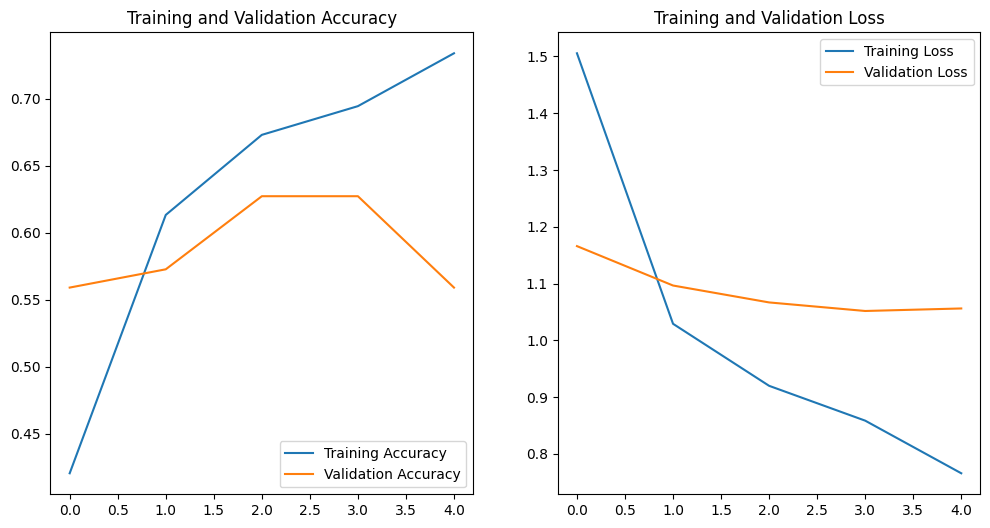

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5729 - loss: 1.0495
Test Accuracy After Fine-tuning: 58.33%


In [6]:
def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_acc_loss(history)
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

# Fine-Tuning and Re-Training

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.3263 - loss: 1.6464 - val_accuracy: 0.5500 - val_loss: 1.1277
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6275 - loss: 1.0321 - val_accuracy: 0.5909 - val_loss: 1.0656
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.6674 - loss: 0.9033 - val_accuracy: 0.5864 - val_loss: 1.0540
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7560 - loss: 0.7778 - val_accuracy: 0.6091 - val_loss: 0.9858
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7263 - loss: 0.7830 - val_accuracy: 0.5909 - val_loss: 1.0682


# Plot Accuracy and Loss After Transfer Learning

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7276 - loss: 0.7278 - val_accuracy: 0.6045 - val_loss: 1.0378
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7495 - loss: 0.7099 - val_accuracy: 0.6091 - val_loss: 1.0895
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7567 - loss: 0.7014 - val_accuracy: 0.6227 - val_loss: 1.0201
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7637 - loss: 0.6623 - val_accuracy: 0.6045 - val_loss: 1.1018
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7955 - loss: 0.5921 - val_accuracy: 0.5682 - val_loss: 1.0953


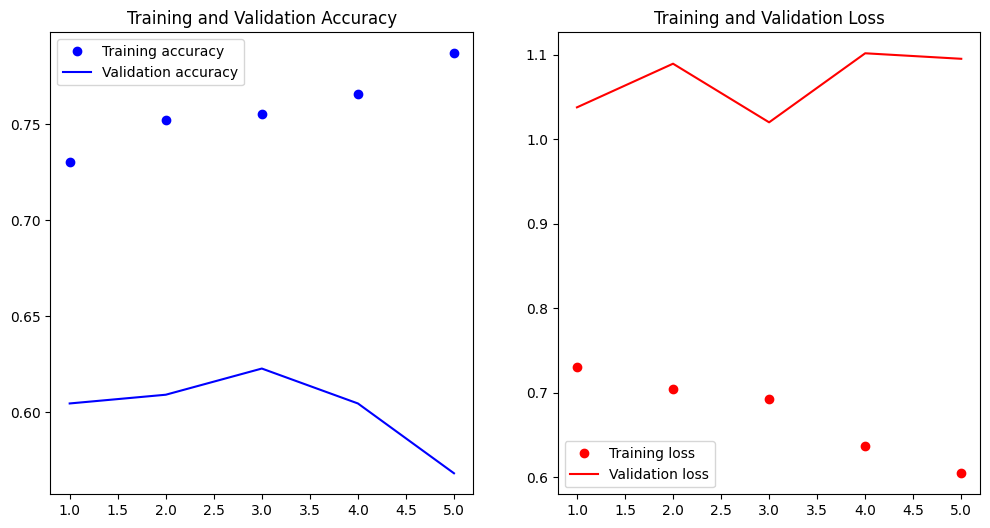

In [8]:
fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)
import matplotlib.pyplot as plt

def plot_acc_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_acc_loss(fine_tune_history)


# Final Evaluation and Display Predictions

In [9]:
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Test Accuracy After Fine-tuning: {test_acc*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5642 - loss: 1.1272
Test Accuracy After Fine-tuning: 56.25%


# Display Classification Metrics and Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


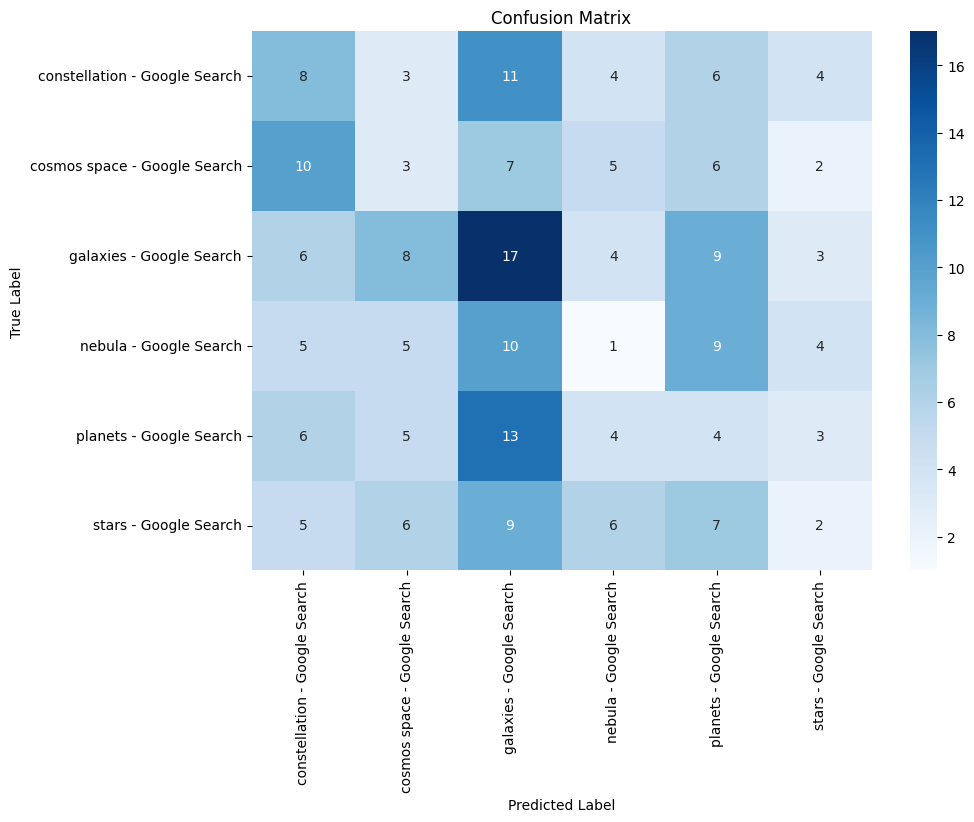

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def display_confusion_matrix(true_classes, predicted_classes, class_labels):
    """
    This function computes and displays a confusion matrix.
    """
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

import numpy as np

predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Call the display function with correct variables
display_confusion_matrix(true_classes, predicted_classes, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


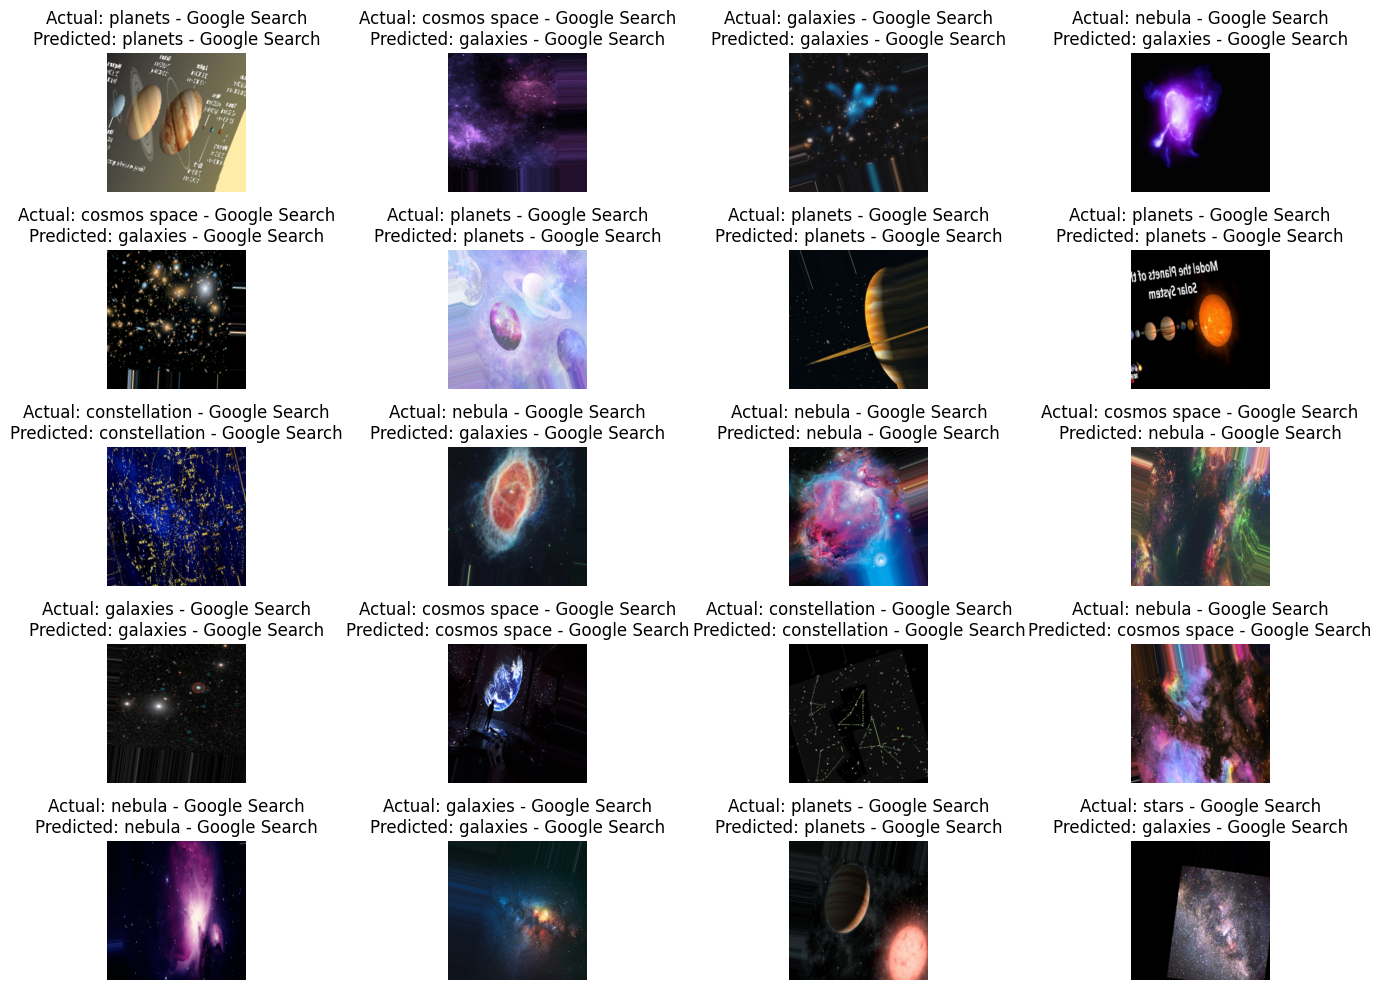

In [12]:
def display_predictions(model, generator, num_images=20):
    """
    This function fetches a batch of images, predicts using the model,
    and displays the images with actual and predicted labels.
    """
    generator.reset()  # Resetting the generator to avoid shuffling issues
    x, y_true = next(generator)
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(5, 4, i + 1)  # Adjust subplot grid for the number of images
        plt.imshow(x[i])
        plt.title(f'Actual: {class_labels[true_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, validation_generator, num_images=20)